## Lab 4: Gridded data in Python

**Objectives:**
   * We will learn how to read, inspect, and write gridded data using <code>rasterio</code> and <code>xarray</code>.
   * Learn how to index, slice and manipulate our gridded data.
   * Export our data as <code>GeoTIFF</code> or <code>NetCDF</code> format.

We will start by reading/writing some remote sensing data where each band is saved as separate <code>GeoTIFFs</code>. After that, we will read some climate reanalysis data saved as <code>NetCDF</code> format.

The questions are the end of the notebook.

### Check for any updates in course materials

Before we start this assignment, we need to check whether there are any updates to the original course repository. We can do this by adding the original repository (the one we forked) as a *remote*. Command line users can do this by running:

<code>git fetch upstream</code>

<code>git merge upstream/master master</code>

GitHub Desktop users should first click the **Fetch origin** button to check for new changes. Then click the triangle symbol next to **Current branch: master**, click **Choose a branch to merge into master**, click **upstream/master** from **Other branches** and click **Create a merge commit**. 

Any new updates to the course repository will now be available in your local repository.

### Download the data for the lab

We will be using some Landsat 8 and ERA5 climate reanalysis data. Since the max file size for GitHub is 2 GB, the lab data will be available on Dropbox (see Slack (or Canvas) for link). Go ahead and download all seven Landsat `.TIF` files and the ERA5 `.nc` file to your local machine. 

### Create a new environment and launch the notebook

As always, make a new environment that contains all the packages for this lab. Navigate to the `labs/lab4` folder (either from the terminal for Linux and Mac users or from the **CMD.exe Prompt** launched from **Anaconda Navigator** for Windows users) and run:

`conda env create -f environment.yml`

Activate this environment by running:

`conda activate lab4`

Now launch the lab demo notebook (if you haven't already): https://nbviewer.org/github/JohnnyRyan1/geospatial-data-science/blob/master/labs/lab4/lab4_demo.ipynb

Now we are ready to start...

In [1]:
# Import packages
import os
import glob

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

import numpy as np
import rasterio
import xarray

## Read and inspect a Landsat 8 raster layer

In [2]:
# Define filepath
filepath = '/Users/jryan4/Dropbox (University of Oregon)/Teaching/geospatial-data-science/data/lab4/'

# Define list of Landsat bands
files = sorted(glob.glob(filepath + 'landsat/*.tif'))
print(files)

['/Users/jryan4/Dropbox (University of Oregon)/Teaching/geospatial-data-science/data/lab4/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B1.tif', '/Users/jryan4/Dropbox (University of Oregon)/Teaching/geospatial-data-science/data/lab4/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B2.tif', '/Users/jryan4/Dropbox (University of Oregon)/Teaching/geospatial-data-science/data/lab4/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B3.tif', '/Users/jryan4/Dropbox (University of Oregon)/Teaching/geospatial-data-science/data/lab4/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B4.tif', '/Users/jryan4/Dropbox (University of Oregon)/Teaching/geospatial-data-science/data/lab4/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B5.tif', '/Users/jryan4/Dropbox (University of Oregon)/Teaching/geospatial-data-science/data/lab4/landsat/LC08_L2SP_047029_20200814_20210330_02_T1_SR_B6.tif', '/Users/jryan4/Dropbox (University of Oregon)/Teaching/geospatial-data-science/data/lab4/landsat/LC

Next, open a single band from your Landsat scene. 

In [3]:
# Open a single band
src = rasterio.open(files[0])
band_1 = src.read(1)

The dataset's **profile** contains number of parameters, several of which are required for georeferencing and writing a new dataset

In [4]:
# Find metadata (e.g. driver, data type, coordinate reference system, transform etc.)
print(src.profile)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': 0.0, 'width': 1208, 'height': 1422, 'count': 1, 'crs': CRS.from_epsg(32610), 'transform': Affine(30.0, 0.0, 391695.0,
       0.0, -30.0, 4880565.0), 'tiled': False, 'interleave': 'band'}


We can also get some of these parameters separately.

In [5]:
# Find coordinate reference system
src.crs # https://epsg.io/32610

CRS.from_epsg(32610)

In [6]:
# Find format
src.driver

'GTiff'

In [7]:
# Find pixel size
src.transform[0]

30.0

In [8]:
# Find bounds of dataset
src.bounds

BoundingBox(left=391695.0, bottom=4837905.0, right=427935.0, top=4880565.0)

In [9]:
# Get corners of dataset
full_extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]
print(full_extent)

[391695.0, 427935.0, 4837905.0, 4880565.0]


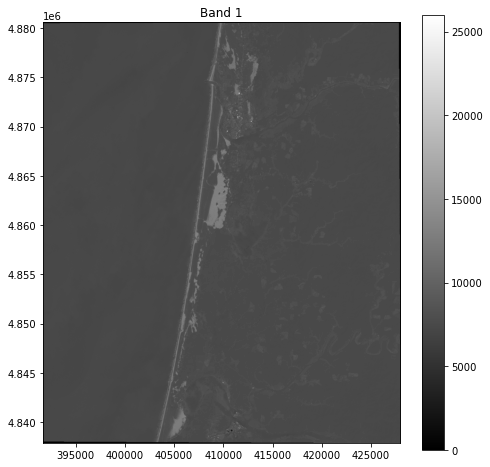

In [10]:
# Plot dataset
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(band_1, cmap='gray', extent=full_extent)
ax.set_title("Band 1")
fig.colorbar(im, orientation='vertical')
plt.show()

Since the raster is read as an NumPy array (called <code>band_1</code>), we can use standard Python methods to find the dimensions, shape, and size of it.

In [11]:
# Find number of columns and rows in array
band_1.shape

(1422, 1208)

In [12]:
# Find total number of pixels in array
band_1.size

1717776

In [13]:
# Find maximum value in array
band_1.max()

25983

In [14]:
# Find datatype
band_1.dtype

dtype('uint16')

In [15]:
# Find maximum possible value in array
2**16

65536

In [16]:
# Find file size (in MB)
band_1.nbytes / 1000000

3.435552

### Produce a true color image from multiple Landsat 8 bands

We often stack Landsat bands so we can conduct our analysis on all bands at the same time. The code below takes each band that you opened, and stacks it into a new single output array. 

In [17]:
# Open all bands in a loop
list_bands = []
for file in files:
    # Read band
    src = rasterio.open(file)
    band = src.read(1)
    
    # Append to list
    list_bands.append(band)

# Convert from list of arrays to n-dimensional array
all_bands = np.dstack(list_bands)

In [18]:
all_bands.shape

(1422, 1208, 8)

We can actually pass a 3-band array to imshow and plot it as an RGB image because it is such a common image format. See [doc here](https://matplotlib.org/3.3.3/api/_as_gen/matplotlib.pyplot.imshow.html) for (M, N, 3) array input. But first we have to convert our values so they have a range of 0-255. We will also produce a new NumPy array that represents just the Red, Green, and Blue bands using the following as a guide: https://www.usgs.gov/media/images/landsat-8-band-designations.

In [19]:
# Convert values to a range of 0-255
all_bands_image = np.uint8((all_bands / 65536) * 255)

In [20]:
# Produce a new array by stacking the RGB bands
rgb = np.dstack((all_bands_image[:,:,3],all_bands_image[:,:,2],all_bands_image[:,:,1]))

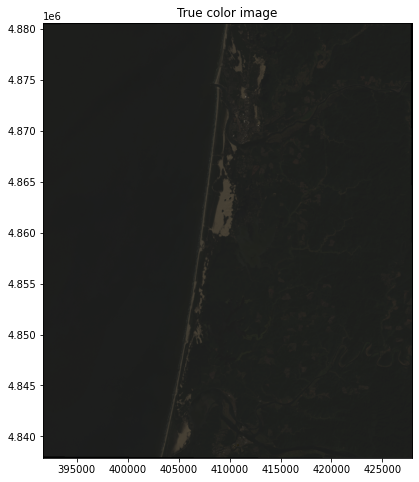

In [21]:
# Plot as RGB image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(rgb, extent=full_extent)
ax.set_title("True color image")
plt.show()

### Compute a band ratio

We can compute a Normalized Difference Water Index (NDWI) using the Green and NIR bands. 

NDWI = (Band 3 - Band 5) / (Band 3 + Band 5)

Remember that arrays are zero indexed, so the first layer is corresponds to <code>all_bands[:,:,0]</code>. Also note that we have to make sure our bands are converted to <code>float</code> datatypes.

In [1]:
# Compute NDWI
np.seterr(divide='ignore', invalid='ignore')
ndwi = np.divide((all_bands[:,:,2].astype(float) - all_bands[:,:,4].astype(float)), \
                 (all_bands[:,:,2].astype(float) + all_bands[:,:,4].astype(float)))

NameError: name 'np' is not defined

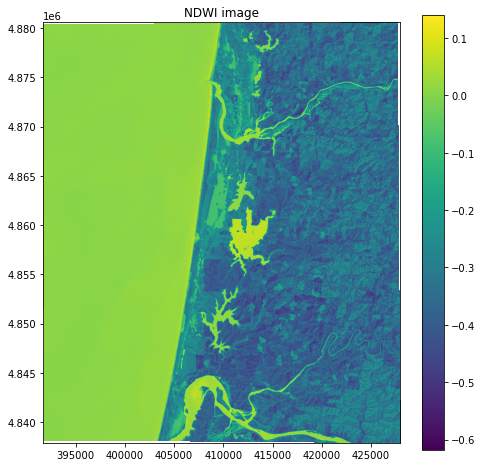

In [24]:
# Plot NDWI image
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(ndwi, extent=full_extent)
ax.set_title("NDWI image")
fig.colorbar(im, orientation='vertical')
plt.show()

We can now see which pixels are likely to be ocean, rivers, or lakes.

### Write true color composite to GeoTIFF

In [25]:
# Write an array as a raster band to a new 8-bit file. For the new file's profile, 
# we start with the profile of the source
profile = src.profile

# And then change the band count to 3, set the dtype to uint8, and specify LZW compression.
profile.update(dtype=rasterio.uint8, count=3, compress='lzw')

In [26]:
with rasterio.open(filepath + 'landsat/rgb.tif', 'w', **profile) as dst:
    # Write array
    dst.write(np.rollaxis(rgb, axis=2)) # Note that array needs to be in bands, rows, cols order (z, y, x)

## Read climate reanalysis data

We usually use the <code>netCDF4</code> or <code>xarray</code> packages for this task.

In [27]:
# Read data
xds = xarray.open_dataset(filepath + 'era/usa_t2m_tcc_2020.nc', decode_coords='all')

In [28]:
xds

<xarray.Dataset>
Dimensions:    (longitude: 233, latitude: 99, time: 1464)
Coordinates:
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -67.5 -67.25 -67.0
  * latitude   (latitude) float32 49.24 48.99 48.74 48.49 ... 25.24 24.99 24.74
  * time       (time) datetime64[ns] 2020-01-01 ... 2020-12-31T18:00:00
Data variables:
    t2m        (time, latitude, longitude) float32 ...
    tcc        (time, latitude, longitude) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2022-01-05 17:55:44 GMT by grib_to_netcdf-2.23.0: /opt/ecmw...

This looks a bit overwelming but it nice way to store gridded data. Below is a schematic of what an xarray data structure represents.


<br>
<div>
<img src="images/xarray_data_structures.png" width="600"/>
</div>

In [29]:
# Print the time period of the data
print('The data ranges from %s to %s' %(xds['t2m']['time'].values.min(), xds['t2m']['time'].values.max()))

The data ranges from 2020-01-01T00:00:00.000000000 to 2020-12-31T18:00:00.000000000


So we know the data spans one year but there are 1464 dimensions in the time variable. This means that the reanalysis data must have a temporal resolution of 6 hours. So before we continue we will resample to daily temporal resolution.

In [30]:
xds_daily = xds.resample(time='1D').mean()
xds_daily

<xarray.Dataset>
Dimensions:    (time: 366, longitude: 233, latitude: 99)
Coordinates:
  * time       (time) datetime64[ns] 2020-01-01 2020-01-02 ... 2020-12-31
  * longitude  (longitude) float32 -125.0 -124.8 -124.5 ... -67.5 -67.25 -67.0
  * latitude   (latitude) float32 49.24 48.99 48.74 48.49 ... 25.24 24.99 24.74
Data variables:
    t2m        (time, latitude, longitude) float32 280.6 281.4 ... 296.3 296.2
    tcc        (time, latitude, longitude) float32 0.9765 0.8814 ... 0.2124

### Plot climate reanalysis data

Now each layer in the dataset corresponds to a single day. Let's plot the air temperature and cloud cover for the day which the Landsat image was acquired (August 14, 2020).

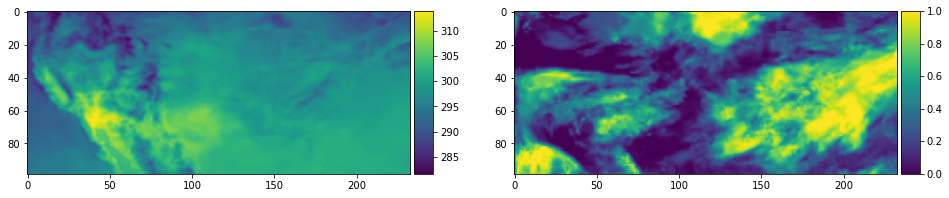

In [31]:
# Plot data
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
im1 = ax1.imshow(xds_daily['t2m'][226,:,:])
divider = make_axes_locatable(ax1)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical')

im2 = ax2.imshow(xds_daily['tcc'][226,:,:])
divider = make_axes_locatable(ax2)
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical')

### Weather in Florence, OR

So we know that is was relatively cold, cloud-free day in Florence, just like we see in the Landsat image. But how anomalous were these conditions? We can investigate by finding the nearest climate reanalysis grid cell to Florence, OR. First we will define the latitude and longitude of Florence. 

In [32]:
# Next, find the index of the grid point nearest a specific lat/lon.   
florence_weather = xds_daily.sel(latitude=43.974659, longitude=-124.103142, method='nearest')

In [33]:
# Note: Aug 14 is DOY 226
print('Cloud cover in Florence on Aug 14, 2020 = %.2f %%' % (florence_weather['tcc'][226].values * 100))

Cloud cover in Florence on Aug 14, 2020 = 0.02 %


In [34]:
fahrenheit = (florence_weather['t2m'][226].values - 273.15) * 9/5 + 32
print('Air temperature in Florence on Aug 14, 2020 = %.2f F' % (fahrenheit))

Air temperature in Florence on Aug 14, 2020 = 62.25 F


### Plot time series

These values look about right. Now we can plot the time series.

Text(0, 0.5, 'Cloud cover (%)')

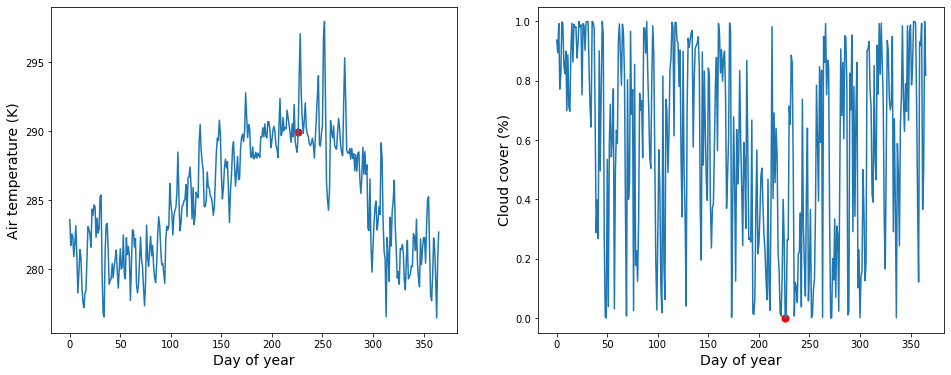

In [35]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
ax1.plot(florence_weather['t2m'])
ax1.scatter(226, florence_weather['t2m'][226], s=50, color='r')
ax1.set_xlabel('Day of year', fontsize=14)
ax1.set_ylabel('Air temperature (K)', fontsize=14)

ax2.plot(florence_weather['tcc'])
ax2.scatter(226, florence_weather['tcc'][226], s=50, color='r')
ax2.set_xlabel('Day of year', fontsize=14)
ax2.set_ylabel('Cloud cover (%)', fontsize=14)

### Find mean values

It was a pretty nice warm day in Florence on Aug 14, 2020 relative to mean annual conditions. But what is the actual mean?

In [36]:
mean_temp = (florence_weather['t2m'].mean() - 273.15) * 9/5 + 32
print('Mean air temp. in Florence in 2020 = %.2f F' % (mean_temp))

Mean air temp. in Florence in 2020 = 53.55 F


In [37]:
mean_cloud = florence_weather['tcc'].mean()
print('Mean cloud cover in Florence in 2020 = %.2f %%' % (mean_cloud * 100))

Mean cloud cover in Florence in 2020 = 58.76 %


Finally, let's calculate how many days had less than 20% cloud cover in Florence

In [38]:
days = np.sum(florence_weather['tcc'] < 0.2).values
print('There were %.0f days with less than 20%% cloud cover in 2020' % days)

There were 61 days with less than 20% cloud cover in 2020


***********
## Question 1 (10 points): 

Now that we have gone through some examples in the lecture and lab we are ready to apply some of these methods ourselves. Start by making a **new** `jupyter notebook` called `lab4_submission.ipynb` and complete the following tasks. 

Find the following numbers in the climate reanalysis dataset:

* a) the air temperature (in F) **and** cloud cover (in %) in Florence, OR (in 2020) on **January 31, 2020**?
* b) the air temperature (in F) **and** cloud cover (in %) in **Eugene, OR** (in 2020) on **February 15, 2020**?

You can use the following table to convert from a **date** to a **day-of-year**: https://landweb.modaps.eosdis.nasa.gov/browse/calendar.html


*******
## Question 2 (20 points):

Find the following grid cells in the climate reanalysis dataset and provide a rough location of where they are located. 

* a) Highest average air temperature (i.e. hottest place)
* b) Lowest average air temperature (i.e. coldest place)
* c) Highest average cloudiness (i.e. cloudiest place)
* d) Lowest average cloudiest (i.e. least cloudy place)
* e) Place with highest range in air temperature
* f) Place with the absolute coldest temperature on a single day 

You can use the following link to convert your lat/lons to an address: https://www.latlong.net/Show-Latitude-Longitude.html

**********

## Question 3 (20 points): 

Display the Landsat image of Florence, OR as:

* a) an **NDVI** image (i.e. (Band 5 - Band 4) / (Band 5 + Band 4))
* b) a **color infrared composite** (i.e. bands 5, 4, 3)

*********

## Question 4 (for grad students/extra credit)

* a) Produce an NDWI histogram for the Landsat image of Florence 
* b) Choose a threshold and produce a binary water mask
* c) Compute the area of water in the image (including ocean)


## Remember to submit your answers to Questions 1, 2 and 3 **by Friday 11:59pm**

In [39]:
# HINT use argmax() or argmin()
max_value = np.mean(xds_daily['t2m'], axis=0).argmax()
index = np.unravel_index(max_value, np.mean(xds_daily['t2m'], axis=0).shape)